In [1]:
# Standard imports
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

# PyREx imports
from pyrex.digsig import SlowAskaryanSignal, FastAskaryanSignal

In [2]:
# Signal plotting helper function
def plot_sig(signal, alternate_values=None, zoom=None, title=None, figsize=(6,4)):
    plt.figure(figsize=figsize)
    if alternate_values is not None:
        values = alternate_values
    else:
        values = signal.values
    if zoom is not None:
        ts = []
        vs = []
        for t,v in zip(signal.times,values):
            if t<zoom[0]:
                continue
            elif t>zoom[1]:
                break
            ts.append(t)
            vs.append(v)
        plt.plot(np.array(ts)*1e9, vs)
    else:
        plt.plot(signal.times*1e9, values)
    if title is not None: plt.title(title)
    plt.xlabel("Time (ns)")

# Test Askaryan Pulses

Make signal object

In [4]:
times = np.linspace(0, 100e-9, 10001)
n = 1.75
theta_c = np.arcsin(np.sqrt(1 - 1/n**2))
angle = theta_c - 0.3*np.pi/180 # radians
print("angle =",angle*180/np.pi,"degrees")
energy = 3e6 # TeV
t0 = 25e-9 # seconds
start_time = time()
ask = SlowAskaryanSignal(times, energy=energy, theta=angle, t0=t0, n=n)
end_time = time()
print("Generating an Askaryan pulse with",len(times),"points took", end_time-start_time, "seconds")
print(round((end_time-start_time)/len(times)*1000,2),"ms per time point")

angle = 54.850095421 degrees
Generating an Askaryan pulse with 10001 points took 99.50587797164917 seconds
9.95 ms per time point


First make sure that the longitudinal shower profile makes sense

Integral:  2.29306854455e-09


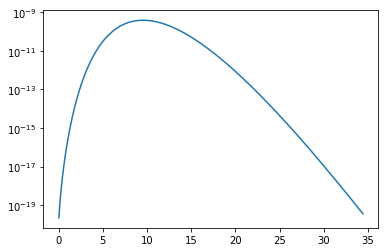

In [5]:
z_min = 0
z_max = 2.5*ask.max_length()
n_z = 1000
z_vals, dz = np.linspace(z_min, z_max, n_z, endpoint=False, retstep=True)
Q = np.zeros(n_z)
for i, z in enumerate(z_vals):
    Q[i] = ask.charge_profile(z)
plt.semilogy(z_vals, Q)
print("Integral: ", np.trapz(Q, dx=dz))

Next check the RAC distribution

Should peak around 1e-5 with the normalization factor applied. Width should be about .5 ns at 1e-6 and 1 ns at 1e-7

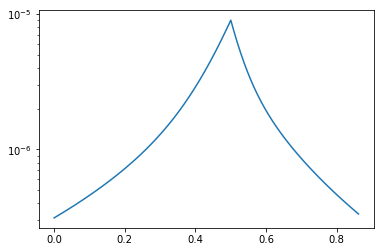

In [6]:
t = 25.5e-9
z_to_t = -(1 - n*np.cos(angle))/3e8
RA_C = np.zeros(n_z)
for j, z in enumerate(z_vals):
    RA_C[j] = ask.RAC(t - t0 - z*z_to_t)
normalization = 1e8 / energy
plt.semilogy(z_vals*z_to_t*1e9, -1*RA_C*normalization)

Now check the vector potential

For a 3 EeV shower 0.3 degrees off the Cherenkov angle, expect a peak around 7e-8 volt-seconds and a width of about 3 ns

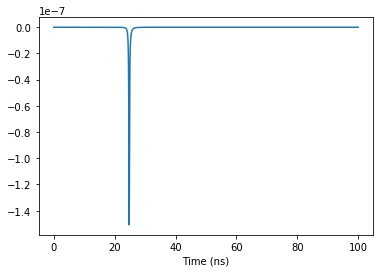

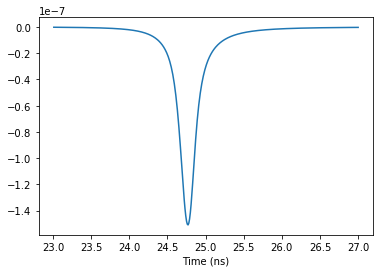

In [11]:
plot_sig(ask, alternate_values=ask.vec_pot)
plot_sig(ask, alternate_values=ask.vec_pot, zoom=[23e-9,27e-9])

Finally, check that the waveform looks correct

For a 3 EeV shower 0.3 degrees of the Cherenkov angle, expect an amplitude of about 200 volts (when multiplied by R, assumed to be 1 meter in the signal code anyway) and a width of about 1 ns

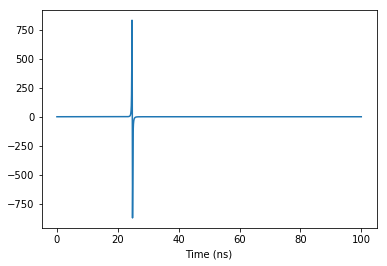

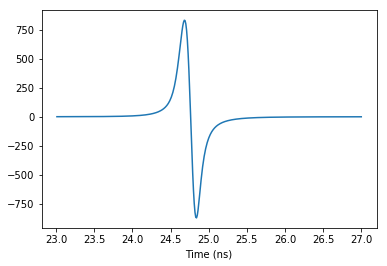

In [13]:
plot_sig(ask)
plot_sig(ask, zoom=[23e-9,27e-9])

# Test Faster Askaryan Pulses

Make signal object

In [3]:
times = np.linspace(0, 100e-9, 10001, endpoint=True)
n = 1.75
theta_c = np.arcsin(np.sqrt(1 - 1/n**2))
angle = theta_c - 0.3*np.pi/180 # radians
print("angle =",angle*180/np.pi,"degrees")
energy = 3e6 # TeV
t0 = 25e-9 # seconds
start_time = time()
ask = FastAskaryanSignal(times, energy=energy, theta=angle, t0=t0, n=n)
end_time = time()
print("Generating an Askaryan pulse with",len(times),"points took", end_time-start_time, "seconds")
print(round((end_time-start_time)/len(times)*1e6,2),"microseconds per time point")

angle = 54.850095421 degrees
10001
10001
10000
Generating an Askaryan pulse with 10001 points took 0.11747384071350098 seconds
11.75 microseconds per time point


Check the shower profile and RAC distributions, as well as their convolution

dz = 0.399687028612
n_Q = 86
LQ_tot = 2.29306854452e-09


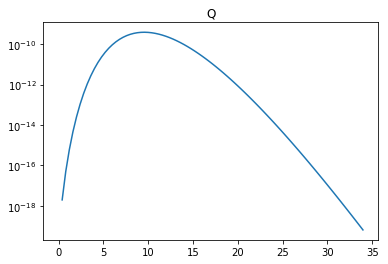

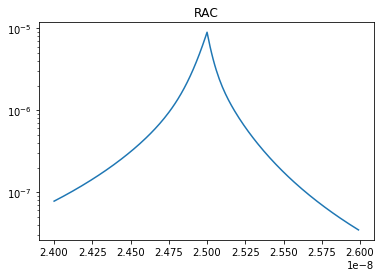

10001 == 10001 ?


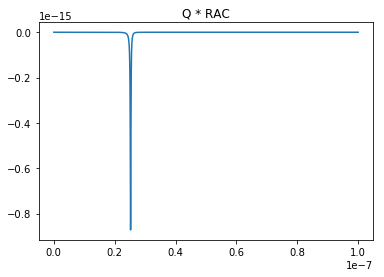

In [21]:
# Conversion factor for z in RAC
z_to_t = (1 - n*np.cos(angle))/3e8

dt = times[1] - times[0]
dz = np.abs(dt / z_to_t)
print("dz =",dz)

z_max = 2.5*ask.max_length()
n_Q = int(z_max/dz)
print("n_Q =",n_Q)
z_Q_vals = np.arange(n_Q)
z_Q_vals = z_Q_vals * dz
Q = np.zeros(n_Q)
for i, z in enumerate(z_Q_vals):
    Q[i] = ask.charge_profile(z)
print("LQ_tot =", np.trapz(Q, dx=dz))

plt.semilogy(z_Q_vals, Q)
plt.title("Q")
plt.show()

n_RAC = len(times) + 1 - n_Q
z_RAC_vals = np.arange(n_RAC)
z_RAC_vals = z_RAC_vals * dz
RA_C = np.zeros(n_RAC)
for i, z in enumerate(z_RAC_vals):
    RA_C[i] = ask.RAC(t0 + z*z_to_t)

normalization = 1e8 / energy
plt.semilogy(z_RAC_vals[2400:2600]*-z_to_t, -1*RA_C[2400:2600]*normalization)
plt.title("RAC")
plt.show()

conv = scipy.signal.convolve(Q,RA_C, mode='full')
print(len(times),"==",len(conv),"?")
plt.plot(times, conv)
plt.title("Q * RAC")
plt.show()

Now check the vector potential

For a 3 EeV shower 0.3 degrees off the Cherenkov angle, expect a peak around 7e-8 volt-seconds and a width of about 3 ns

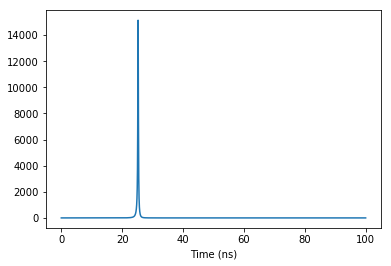

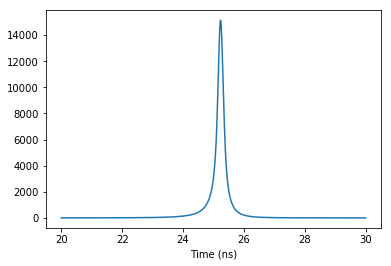

In [22]:
plot_sig(ask, alternate_values=ask.vec_pot)
plot_sig(ask, alternate_values=ask.vec_pot, zoom=[20e-9,30e-9])

Finally, check that the waveform looks correct

For a 3 EeV shower 0.3 degrees of the Cherenkov angle, expect an amplitude of about 200 volts (when multiplied by R, assumed to be 1 meter in the signal code anyway) and a width of about 2 ns

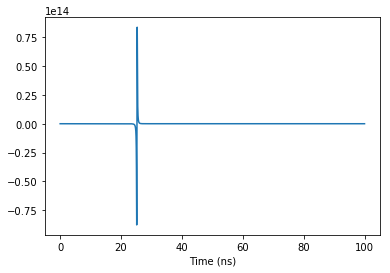

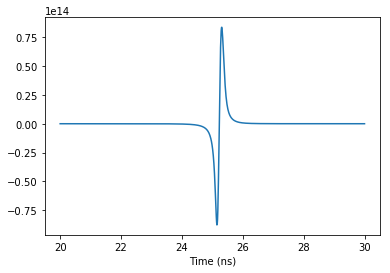

In [23]:
plot_sig(ask)
plot_sig(ask, zoom=[20e-9,30e-9])